In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import astropy.units as u
import astropy.constants as c
import astropy.units as cu
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
from Corrfunc.theory import DDrppi, DD
from Corrfunc.utils import convert_rp_pi_counts_to_wp, convert_3d_counts_to_cf
sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import photxspec
import corrfuncs
import tools
from linear_theory import powerspec_to_wlin

### alternative Limber formula

In the limit of a narrow spectroscopic bin around $z=z_i$,
\begin{eqnarray}
w_x(\theta) &=& \int\mathrm{d}\chi W_\mathrm{phot}(\chi)W_i(\chi)\int_{-\infty}^\infty\mathrm{d}x_{||}\xi_x\left(\sqrt{x_{||}^2+\chi^2\theta^2};z_i\right) \\
&\approx& \frac{1}{N_\mathrm{phot}}\frac{\mathrm{d}N_\mathrm{phot}}{\mathrm{d}\chi}(z=z_i)\,w_{p,x}(\chi\theta;z_i)
\end{eqnarray}

** This includes all non-linear and quasi-linear effects, and can be easily used to estimate the cross-correlation $w_x$ for arbitrary $\mathrm{d}N_\mathrm{phot}/\mathrm{d}z$.

We can compare to our usual linear formula
$$
w_{x,\mathrm{lin}}(\theta)\approx\frac{1}{N_\mathrm{phot}}\frac{\mathrm{d}N_\mathrm{phot}}{\mathrm{d}\chi}(z_i)\,b_\mathrm{phot}(z_i)\,b_i(z_i)\,\frac{1}{\chi^2(z_i)}\int_0^\infty\frac{\mathrm{d}\ell}{2\pi}\ell J_0(\ell\theta)\, P_\mathrm{lin}(k=\ell/\chi;z_i)
$$

### load TNG snapshots

In [15]:
# construct SPHEREx-like galaxy samples
snapshots = np.arange(63, 83).astype(int)

sigma_z = 0.1  # one of the 5 redshift error bins in SPHEREx

redshifts = np.empty(len(snapshots))
chis = np.empty(len(snapshots))
gal_pos_specs = []
for i, snapshot in enumerate(snapshots):
    sim = TNGSim('TNG300-3', snapshot=snapshot)
    chi = tools.redshift_to_comov(sim.redshift)
    redshifts[i] = sim.redshift
    chis[i] = chi.value
    
    gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
    gal_pos_spec -= sim.boxsize / 2
    gal_pos_specs.append(gal_pos_spec)

chis *= chi.unit  # give unit back to the chis

 number density for SPHEREx at z=0.6: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
 number density for SPHEREx at z=0.58: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
 number density for SPHEREx at z=0.55: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
 number density for SPHEREx at z=0.52: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
 number density for SPHEREx at z=0.5: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
 number density for SPHEREx at z=0.48: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
 number density for SPHEREx at z=0.46: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
 number density for SPHEREx at z=0.44: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
 number density for SPHEREx at z=0.42: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
 number density for SPHEREx at z=0.4: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
 number density for SPHEREx at z=0.38: 1.29e-02 (h/Mpc)^3 
target number of subhalo

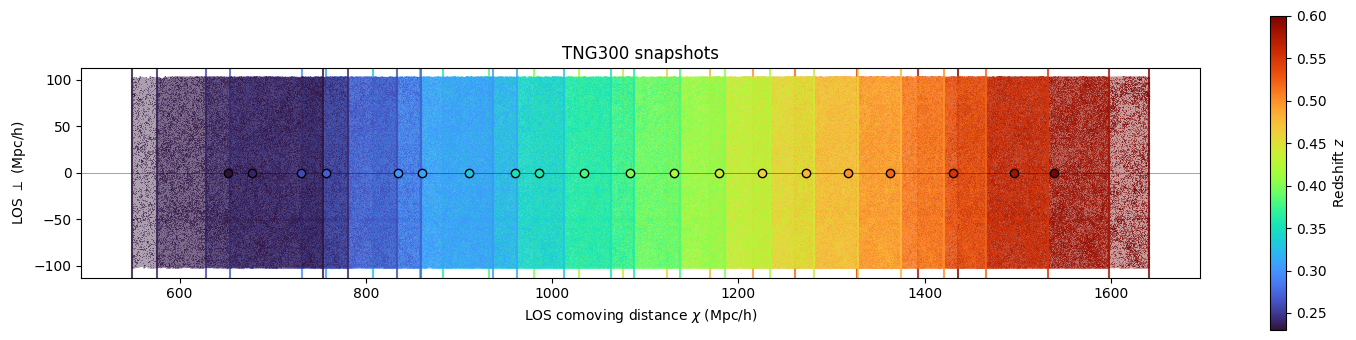

In [17]:
norm = mpl.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(15,3.5), tight_layout=True)
for i, chi in enumerate(chis):
    gal_pos_spec_ = np.copy(gal_pos_specs[i])
    gal_pos_spec_[:,2] += chi
    kwargs = dict(c=smap.to_rgba(redshifts[i]))
    ax.plot(gal_pos_spec_[:,2], gal_pos_spec_[:,0], marker=',', alpha=0.4, **kwargs)
    ax.plot(chi, 0, marker='o', c=smap.to_rgba(redshifts[i]), mec='k', zorder=100)
    ax.axvline((chi - sim.boxsize/2).value, alpha=0.8, **kwargs)
    ax.axvline((chi + sim.boxsize/2).value, alpha=0.8, **kwargs)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.set_aspect('equal')
ax.set_xlabel(r'LOS comoving distance $\chi$ (Mpc/h)')
ax.set_ylabel(r'LOS $\perp$ (Mpc/h)')
ax.set_title(r'TNG300 snapshots')
fig.colorbar(smap, ax=ax, label='Redshift $z$')

### comoving distance $r\ \leftrightarrow$ angular separation $\theta$

In [18]:
# ! note redshift needs to be defined in the TNGSim earlier;
#    to use with mpl axis labels, we need a single input and dimensionless output
def theta_to_r_comov_(theta):  # theta in DEGREES
    return tools.theta_to_r_comov(theta, sim.redshift).value
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, sim.redshift).value

### projected auto-correlation

In [19]:
# inputs
randmult = 3
rmin = 0.1
rmax = 60
nbins = 10
pimax = int(sim.boxsize.value) # max depth to integrate along LOS
nthreads = 10
periodic = False
nrepeats = 10  # how many times to repeat computation to help with noise / numerical errors ?

In [20]:
# what range of angles is this? at min and max redshifts
tools.r_comov_to_theta([rmin,rmax], max(redshifts)).value, tools.r_comov_to_theta([rmin,rmax], min(redshifts)).value

(array([0.00372328, 2.23396628]), array([0.00879387, 5.27632039]))

In [21]:
# compute the projected auto-correlation function in each snapshot
wps_z = np.full((len(snapshots),nbins), np.nan)
for i, gal_pos_spec in enumerate(gal_pos_specs):
    # prep data
    data_for_cf = corrfuncs.set_up_cf_data(gal_pos_spec, randmult=randmult, rmin=rmin, rmax=rmax, nbins=nbins,
                                      boxsize=sim.boxsize, logbins=True)
    rp_edges, rp_avg, nd, _, boxsize, nr, rand_set, data_set, _ = data_for_cf.values()
    assert np.allclose(boxsize, sim.boxsize.value)
    assert np.all(rand_set >= 0) and np.all(rand_set <= boxsize)
    assert np.all(data_set >= 0) and np.all(data_set <= boxsize)
    
    # unpack
    xd, yd, zd = data_set.T
    xr, yr, zr = rand_set.T
    
    wps = np.full((nrepeats,nbins), np.nan)

    for j in range(nrepeats):

        dd_res = DDrppi(1, nthreads, pimax, rp_edges, xd, yd, zd, boxsize=boxsize, periodic=periodic, output_rpavg=True)
        dr_res = DDrppi(0, nthreads, pimax, rp_edges, xd, yd, zd, X2=xr, Y2=yr, Z2=zr, boxsize=boxsize, periodic=periodic)
        rr_res = DDrppi(1, nthreads, pimax, rp_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

        # turn pair counts into actual correlation function: Landy-Szalay estimator
        wps[j] = convert_rp_pi_counts_to_wp(nd, nd, nr, nr, dd_res, dr_res, dr_res, rr_res, nbins, pimax)

    wps_z[i] = np.nanmean(wps, axis=0)  # add the mean across the runs

shifting data by L/2!
shifting data by L/2!


/work/08811/aew492/frontera/venv/illustris/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!
shifting data by L/2!


Text(0.5, 1.0, 'Projected autocorrelations, spectroscopic samples')

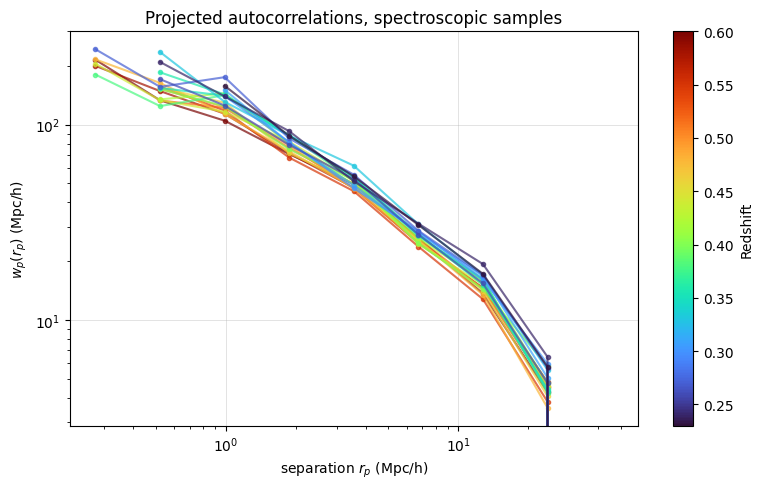

In [22]:
norm = mpl.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, wp in enumerate(wps_z):
    ax.plot(rp_avg, wp, marker='.', alpha=0.7, c=smap.to_rgba(redshifts[i]))
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$ (Mpc/h)')
fig.colorbar(smap, ax=ax, label='Redshift')
ax.set_title(f"Projected autocorrelations, spectroscopic samples")

### photometric weights

In [23]:
# we don't need to actually construct a photometric sample anymore: just get the weights in each snapshot

# redshift error in comoving coordinates
dx = tools.get_dx(np.nanmean(redshifts), sigma_z)
dx

<Quantity 338.28313349 Mpc / littleh>

In [24]:
# on a finer grid
chis_fine = np.linspace(min(chis.value), max(chis.value), 101)
W_phot_fine = [
    tools.eval_Gaussian(chi, dx.value, mean=np.nanmean(chis_fine)) for chi in chis_fine
]

# and at the snapshot centers
W_phot = [
    tools.eval_Gaussian(chi.value, dx.value, mean=np.nanmean(chis_fine)) for chi in chis
]

Text(0.5, 1.0, 'Photometric weights')

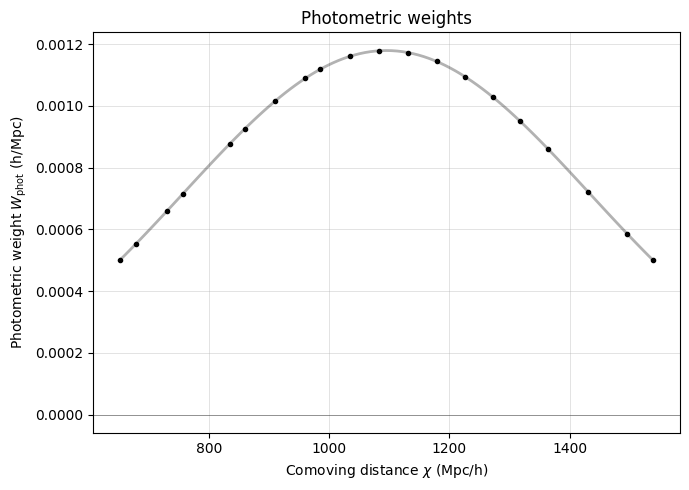

In [25]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(chis_fine, W_phot_fine, 'k-', lw=2, alpha=0.3)
ax.plot(chis.value, W_phot, 'k.', label='Snapshot centers')
ax.axhline(0, alpha=0.5, c='k', lw=0.5)
ax.grid(alpha=0.5, lw=0.5)
# ax.semilogy()
ax.set_xlabel(r'Comoving distance $\chi$ (Mpc/h)')
ax.set_ylabel(r'Photometric weight $W_\mathrm{phot}$ (h/Mpc)')
ax.set_title('Photometric weights')

### angular cross-correlation

In [26]:
# multiply each projected auto-correlation function by the corresponding photometric weight
#  this effectively gives us the angular cross-correlation function
wthetax = np.array([
    W_phot[i] * wps_z[i] for i in range(len(snapshots))
])

Text(0.5, 1.0, 'Phot. x spec. cross-correlation ($\\sigma_z=$0.1; d$x=$338 Mpc/h)')

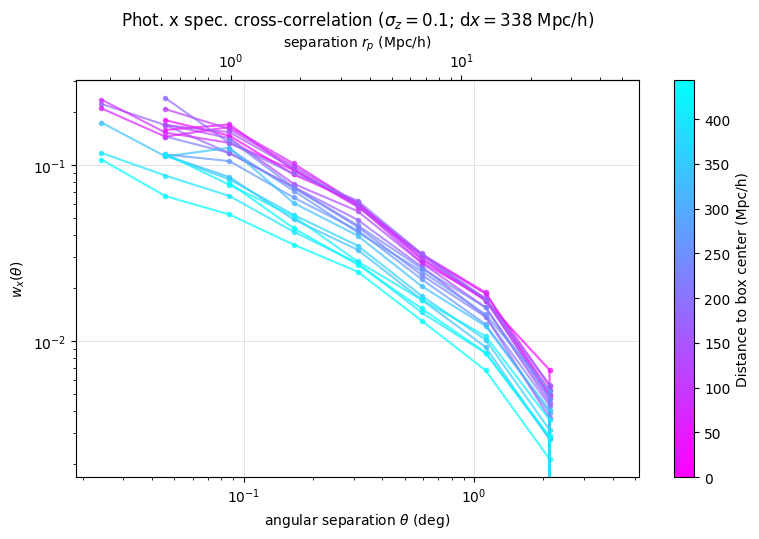

In [27]:
# now color by distance to box center
norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(chis.value-np.nanmean(chis_fine))))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig, ax = plt.subplots(figsize=(8,5.5), tight_layout=True)
for i, w in enumerate(wthetax):
    ax.plot(r_comov_to_theta_(rp_avg), w, marker='.', alpha=0.7, c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))))
secax = ax.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.set_ylabel(r'$w_x(\theta)$')
fig.colorbar(smap, ax=ax, label='Distance to box center (Mpc/h)')
ax.set_title('Phot. x spec. cross-correlation ($\sigma_z=$'f'{sigma_z}; d'r'$x=$'f'{dx.value:.0f} Mpc/h)')

### compare photometric weights for each redshift error $\sigma_z$

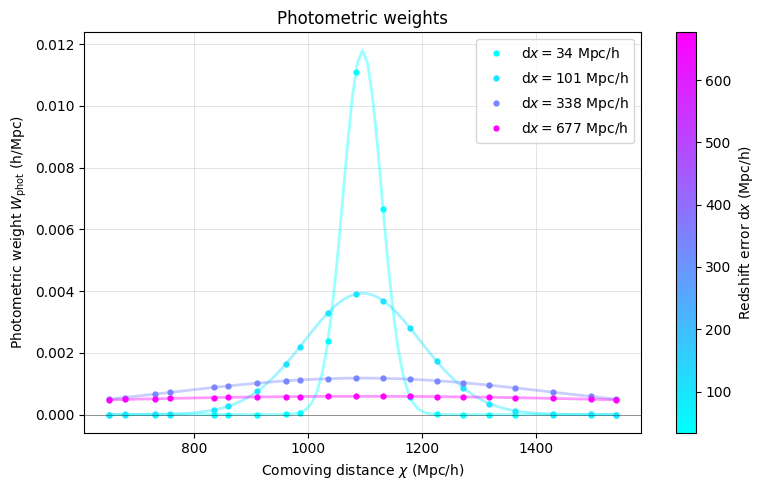

In [28]:
sigma_zs = [0.01, 0.03, 0.1, 0.2]
dxs = np.array([
    tools.get_dx(np.nanmean(redshifts), sigma_z).value for sigma_z in sigma_zs
]) << dx.unit

norm = mpl.colors.Normalize(vmin=min(dxs.value), vmax=max(dxs.value))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

# colors = iter(mpl.cm.cool(np.linspace(0, 1, len(dxs))))

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, dx in enumerate(dxs):
    # c = next(colors)
    
    # on a finer grid
    chis_fine = np.linspace(min(chis.value), max(chis.value), 101)
    W_phot_fine = [
        tools.eval_Gaussian(chi, dx.value, mean=np.nanmean(chis_fine)) for chi in chis_fine
    ]

    # and at the snapshot centers
    W_phot = [
        tools.eval_Gaussian(chi.value, dx.value, mean=np.nanmean(chis_fine)) for chi in chis
    ]
    
    ax.plot(chis_fine, W_phot_fine, ls='-', lw=2, alpha=0.4, c=smap.to_rgba(dx.value))
    ax.plot(chis.value, W_phot, marker='.', ms=7, ls='None', c=smap.to_rgba(dx.value),
            label=r'd$x=$'f'{dx.value:.0f} Mpc/h')

ax.axhline(0, alpha=0.5, c='k', lw=0.5)
ax.grid(alpha=0.5, lw=0.5)
# ax.semilogy()
ax.set_xlabel(r'Comoving distance $\chi$ (Mpc/h)')
ax.set_ylabel(r'Photometric weight $W_\mathrm{phot}$ (h/Mpc)')
ax.set_title('Photometric weights')
ax.legend()
fig.colorbar(smap, ax=ax, label=r'Redshift error d$x$ (Mpc/h)')

### compare to the usual cross-correlation in a single snapshot

In [29]:
# use the snapshot closest to the mean
snapshot = round(np.mean(snapshots))
print(f"snapshot {snapshot}, sigma_z = {sigma_z}") # sigma_z defined at top of notebook

sim = TNGSim('TNG300-3', snapshot=snapshot)
chi = tools.redshift_to_comov(sim.redshift)

gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos_spec -= sim.boxsize / 2

snapshot 72, sigma_z = 0.1
 number density for SPHEREx at z=0.4: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090


In [30]:
# construct photometric sample
dx = tools.get_dx(sim.redshift, sigma_z)
gal_pos_phot = photxspec.construct_photometric_sample(gal_pos_spec, dx)

In [31]:
# divide the spectroscopic sample into slices along the LOS
nslices = 11
losbins = np.linspace(-sim.boxsize.value/2, sim.boxsize.value/2, nslices+1) << sim.boxsize.unit
slicewidth = (losbins[1]-losbins[0])
slice_centers = np.array([(losbins[i].value+losbins[i+1].value)/2 for i in range(nslices)]) << sim.boxsize.unit
slices_spec = [
    gal_pos_spec[(losbins[i] <= gal_pos_spec[:,2]) & (gal_pos_spec[:,2] < losbins[i+1])] \
    for i in range(nslices)
]

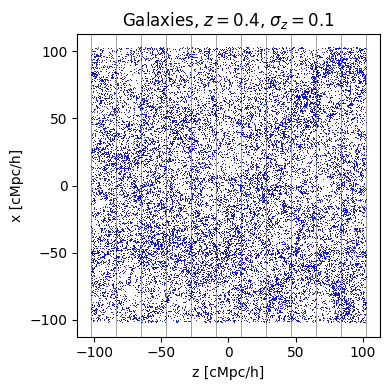

In [32]:
# plot positions
fig, ax = plt.subplots(figsize=(7,4))
kwargs = dict(ls='None', marker=',', alpha=0.6)
ax.plot(gal_pos_spec[:,2].value, gal_pos_spec[:,0].value, c='k', **kwargs)
ax.plot(gal_pos_phot[:,2].value, gal_pos_phot[:,0].value, c='b', **kwargs)
for x in losbins:
    ax.axvline(x.value, ls='-', c='k', lw=0.5, alpha=0.5)
ax.set_aspect('equal')
ax.set_xlabel('z [cMpc/h]')
ax.set_ylabel('x [cMpc/h]')
ax.set_title(f'Galaxies, $z={sim.redshift}$, $\sigma_z={sigma_z}$')
fig.tight_layout()

In [33]:
# ANGULAR CORRELATION FUNCTION in spectroscopic slices

# inputs
# nbins defined above with projected cf
# get thetamin and thetamax from the rp bins used above, at the min redshift box
thetamin = tools.r_comov_to_theta(rmin, min(redshifts)).value
thetamax = tools.r_comov_to_theta(rmax, min(redshifts)).value
print(thetamin, thetamax)
bins = np.logspace(np.log10(thetamin), np.log10(thetamax), nbins+1)

# convert photometric (x,y,z) to (RA,Dec)
ra_phot, dec_phot = tools.get_ra_dec(gal_pos_phot, chi)

xcorrs = np.empty((nslices,nbins))
for i, spec_slice in enumerate(slices_spec):
    # convert spectroscopic (x,y,z) to (RA,Dec)
    idx_spec = (losbins[i] <= gal_pos_spec[:,2]) & (gal_pos_spec[:,2] < losbins[i+1])
    ra_spec, dec_spec = tools.get_ra_dec(gal_pos_spec[idx_spec], chi)
    
    # random set
    ra_rand_phot = np.random.uniform(min(ra_phot.value), max(ra_phot.value), len(ra_phot)) << ra_phot.unit
    dec_rand_phot = np.random.uniform(min(dec_phot.value), max(dec_phot.value), len(dec_phot)) << ra_phot.unit

    thetaavg, xcorrs[i] = corrfuncs.wtheta_cross_PH(ra_phot.value, dec_phot.value, ra_spec.value, dec_spec.value,
                                      ra_rand_phot.value, dec_rand_phot.value, bins)

0.008793867310064409 5.276320386038645


Text(0.5, 1.0, 'Angular cross-correlation, photometric x spectroscopic galaxies, z=0.4')

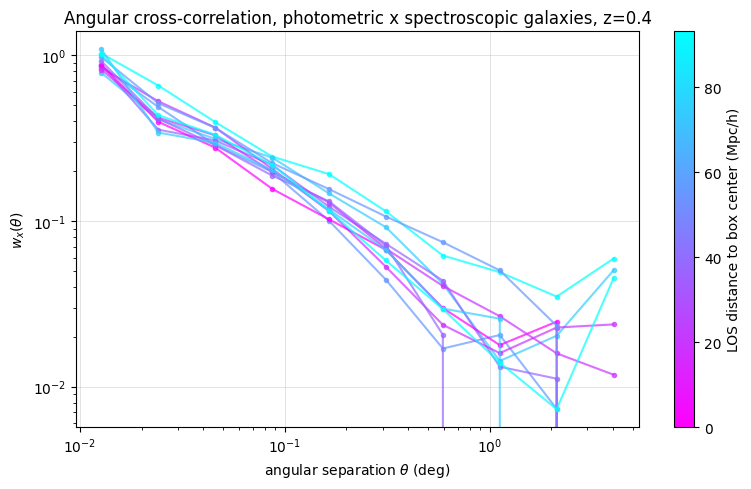

In [34]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers.value))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, xcorr in enumerate(xcorrs):
    ax.plot(thetaavg, xcorr, marker='.', alpha=0.7, c=smap.to_rgba(np.abs(slice_centers[i].value)))
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.set_ylabel(r'$w_x(\theta)$')
fig.colorbar(smap, ax=ax, label='LOS distance to box center (Mpc/h)')
ax.set_title(f"Angular cross-correlation, photometric x spectroscopic galaxies, z={sim.redshift}")

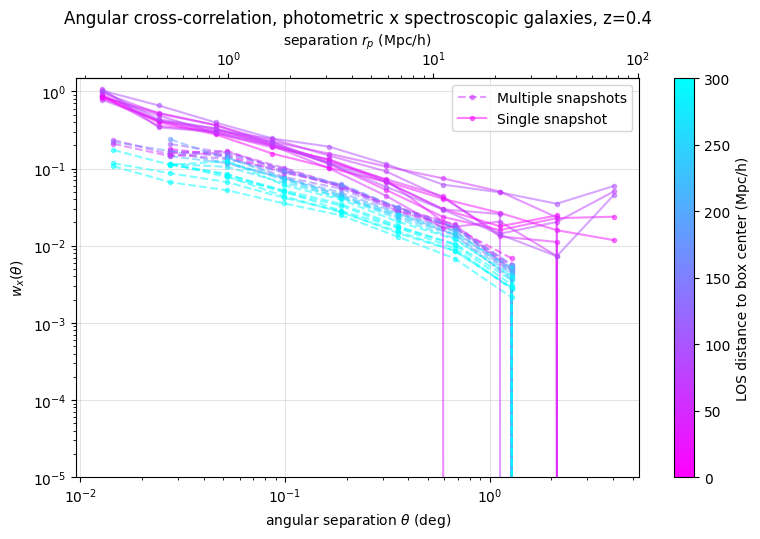

In [35]:
# now add the results from the new method in co-eval boxes
norm = mpl.colors.Normalize(vmin=0, vmax=300) # np.amax(np.abs(chis.value-np.nanmean(chis_fine))))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig, ax = plt.subplots(figsize=(8,5.5), tight_layout=True)
kwargs = dict(marker='.', alpha=0.5)
for i, w in enumerate(wthetax):
    label = 'Multiple snapshots' if i==len(wthetax)//2 else ''
    ax.plot(r_comov_to_theta_(rp_avg), w, ls='--', c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))),
           label=label, **kwargs)
for i, w in enumerate(xcorrs):
    label = 'Single snapshot' if i==len(xcorrs)//2 else ''
    ax.plot(thetaavg, w, ls='-', c=smap.to_rgba(np.abs(slice_centers[i].value)),
           label=label, **kwargs)
secax = ax.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.loglog()
ax.set_ylim(1e-5,None)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.set_ylabel(r'$w_x(\theta)$')
fig.colorbar(smap, ax=ax, label='LOS distance to box center (Mpc/h)')
ax.set_title(f"Angular cross-correlation, photometric x spectroscopic galaxies, z={sim.redshift}")
ax.legend()

### compare to linear theory

\begin{eqnarray}
w_p(\chi\theta;z) &=& \int_{-\infty}^\infty\mathrm{d}x_{||}\xi\left(\sqrt{x_{||}^2+\chi^2\theta^2};z\right) \\
&=& \frac{1}{\chi^2}\int\frac{\mathrm{d}\ell}{2\pi}\,\ell\,J_0(\ell\theta)\,P(k=\ell/\chi(z);z)
\end{eqnarray}

For auto,
$$
P(k=\ell/\chi(z);z) = b^2\,P_\mathrm{lin}(k=\ell/\chi(z);z)
$$

For cross,
$$
P(k=\ell/\chi(z);z) = b_p b_s\,P_\mathrm{lin}(k=\ell/\chi(z);z)
$$

In [36]:
# ! note needs chi to be defined above
def ell_to_k(ell):
    return (ell + 0.5) / chi.value
def k_to_ell(k):
    return (k * chi.value) - 0.5

In [37]:
# power spectrum from colossus
cosmo = cosmology.setCosmology('planck15')
ell = np.logspace(0, 6, 1000)
P = cosmo.matterPowerSpectrum(ell_to_k(ell), sim.redshift)

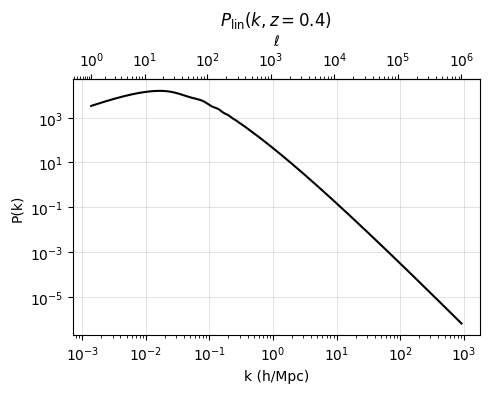

In [38]:
# plot PS
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(ell_to_k(ell), P, 'k-')
secax = ax.secondary_xaxis('top', functions=(k_to_ell, ell_to_k))
secax.set_xlabel(r'$\ell$')
ax.set_xlabel('k (h/Mpc)')
ax.set_ylabel('P(k)')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_title(r'$P_\mathrm{lin}(k,z=$'+f'{sim.redshift:.1f})')
fig.tight_layout()

In [39]:
# get linear bias from spectroscopic sample
_, ratio = photxspec.get_linear_bias(gal_pos_spec, sim, r_edges=rp_edges, return_ratio=True)

/work/08811/aew492/frontera/small-scale_cross-corrs/photxspec.py:229: RuntimeWarning: Mean of empty slice
  bias = np.nanmean(ratio[bias_range[0]:bias_range[1]])


In [40]:
# average r in each bin
ravg = ((rp_edges[1:] + rp_edges[:-1]) / 2) << sim.boxsize.unit

In [41]:
# range to compute linear bias
biasrange = (-5,-2) # indices from ravg
bias = np.mean(ratio[biasrange[0]:biasrange[1]])

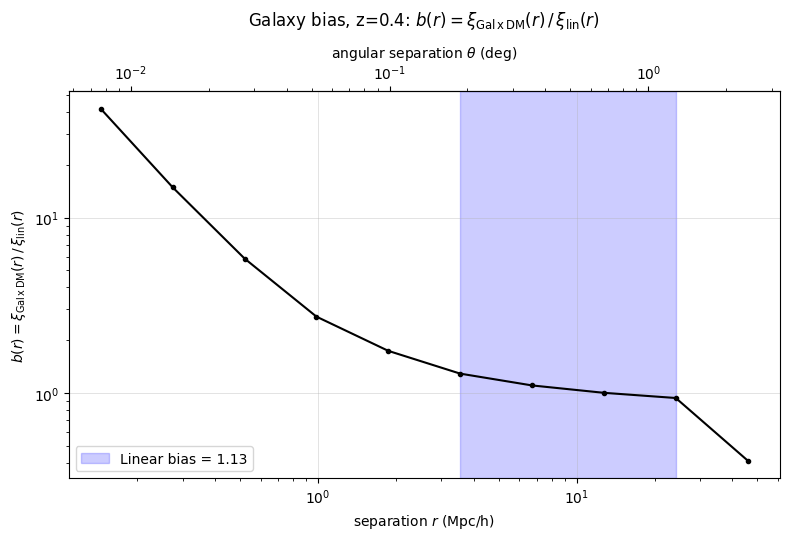

In [42]:
fig, ax = plt.subplots(figsize=(8,5.5), tight_layout=True)
ax.plot(ravg, ratio, 'k.-')
secax = ax.secondary_xaxis('top', functions=(r_comov_to_theta_, theta_to_r_comov_))
secax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.axvspan(ravg[-5].value, ravg[-2].value, color='b', alpha=0.2, label=f'Linear bias = {bias:.2f}')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$b(r) = \xi_\mathrm{Gal\,x\,DM}(r)\,/\,\xi_\mathrm{lin}(r)$')
ax.set_title(f'Galaxy bias, z={sim.redshift}: 'r'$b(r) = \xi_\mathrm{Gal\,x\,DM}(r)\,/\,\xi_\mathrm{lin}(r)$', y=1.15)
ax.legend()

In [43]:
W_phot = [
    tools.eval_Gaussian(chi.value, dx.value, mean=np.nanmean(chis_fine)) for chi in chis
]

In [44]:
# angular power spectrum in each LOS bin
prefactor = 1 / chi**2 * bias**2 * P
C_ells = np.array([
    prefactor * W_phot[i] for i in range(len(snapshots))
])

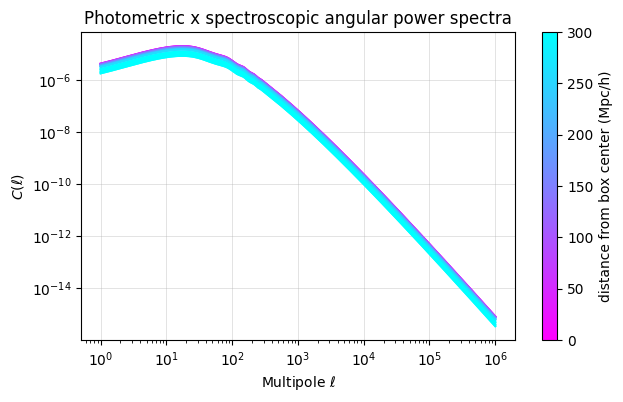

In [45]:
# plot the Cells
fig, ax = plt.subplots(figsize=(7,4))
for i, Cell in enumerate(C_ells):
    ax.plot(ell, Cell, ls='-', c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))))
ax.loglog()
ax.grid(lw=0.5, alpha=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C(\ell)$')
ax.set_title('Photometric x spectroscopic angular power spectra')
fig.colorbar(smap, ax=ax, label='distance from box center (Mpc/h)')

In [46]:
# integrate the power spectra to get the angular correlation function in each LOS bin
wlin_pred = np.zeros((len(C_ells),len(thetaavg)))
for i, Cell in enumerate(C_ells):
    wlin_pred[i] = np.array([
        powerspec_to_wlin(theta_, ell, Cell)[0] for theta_ in thetaavg
    ])

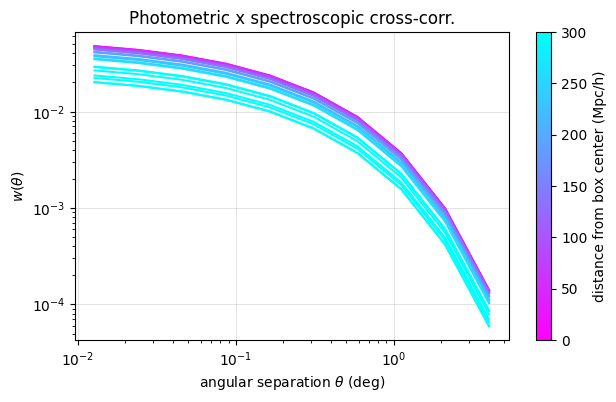

In [47]:
fig, ax = plt.subplots(figsize=(7,4))
for i, wlin_ in enumerate(wlin_pred):
    ax.plot(thetaavg, wlin_, ls='-', c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))))
ax.loglog()
ax.grid(lw=0.5, alpha=0.5)
ax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_title('Photometric x spectroscopic cross-corr.')
fig.colorbar(smap, ax=ax, label='distance from box center (Mpc/h)')

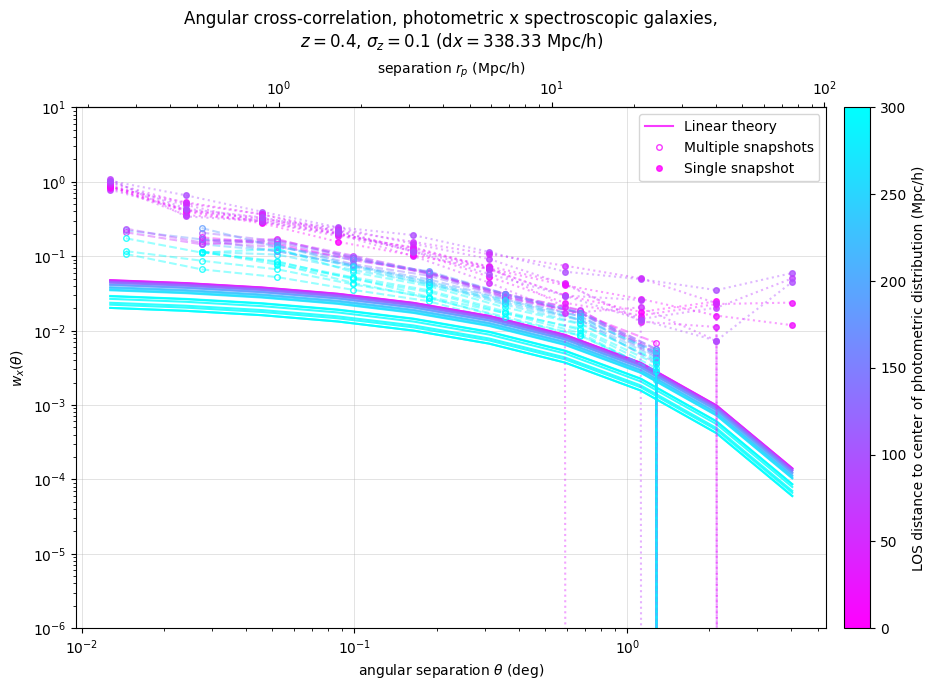

In [50]:
# now overplot the three results together
norm = mpl.colors.Normalize(vmin=0, vmax=300) # np.amax(np.abs(chis.value-np.nanmean(chis_fine))))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig, ax = plt.subplots(figsize=(10,7), tight_layout=True)

for i, w in enumerate(wthetax):
    c = smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine)))
    
    label = 'Linear theory' if i==(len(wthetax)//2)-1 else ''
    ax.plot(thetaavg, wlin_pred[i], ls='-', c=c, alpha=0.8, label=label)
    
    label = 'Multiple snapshots' if i==(len(wthetax)//2)-1 else ''
    ax.plot(r_comov_to_theta_(rp_avg), w, ls='--', c=c, alpha=0.4)
    ax.plot(r_comov_to_theta_(rp_avg), w, ls='None', marker='o', ms=4, mec=c, mfc='None', alpha=0.8, label=label)
    
for i, w in enumerate(xcorrs):
    c = smap.to_rgba(np.abs(slice_centers[i].value))
    label = 'Single snapshot' if i==len(xcorrs)//2 else ''
    ax.plot(thetaavg, w, ls=':', alpha=0.4, c=c)
    ax.plot(thetaavg, w, ls='None', marker='o', ms=4, alpha=0.8, c=c, label=label)
    
secax = ax.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.loglog()
ax.set_ylim(1e-6,1e1)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.set_ylabel(r'$w_x(\theta)$')
fig.colorbar(smap, ax=ax, label='LOS distance to center of photometric distribution (Mpc/h)', pad=.02)
ax.set_title(f"Angular cross-correlation, photometric x spectroscopic galaxies,\n"r"$z=$"f"{sim.redshift}, "
             r"$\sigma_z=$"f"{sigma_z} ("r"d$x=$"f"{dx.value:.2f} Mpc/h)", y=1.1)
ax.legend()

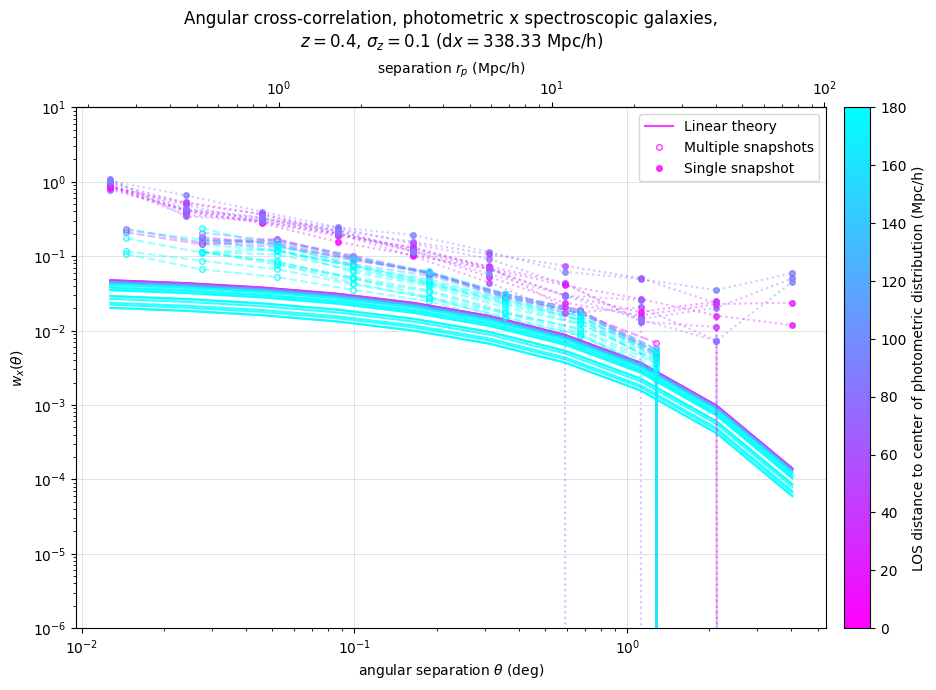

In [49]:
# now overplot the three results together
norm = mpl.colors.Normalize(vmin=0, vmax=180) # np.amax(np.abs(chis.value-np.nanmean(chis_fine))))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig, ax = plt.subplots(figsize=(10,7), tight_layout=True)

for i, w in enumerate(wthetax):
    c = smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine)))
    
    label = 'Linear theory' if i==(len(wthetax)//2)-1 else ''
    ax.plot(thetaavg, wlin_pred[i], ls='-', c=c, alpha=0.8, label=label)
    
    label = 'Multiple snapshots' if i==(len(wthetax)//2)-1 else ''
    ax.plot(r_comov_to_theta_(rp_avg), w, ls='--', c=c, alpha=0.4)
    ax.plot(r_comov_to_theta_(rp_avg), w, ls='None', marker='o', ms=4, mec=c, mfc='None', alpha=0.8, label=label)
    
for i, w in enumerate(xcorrs):
    c = smap.to_rgba(np.abs(slice_centers[i].value))
    label = 'Single snapshot' if i==len(xcorrs)//2 else ''
    ax.plot(thetaavg, w, ls=':', alpha=0.4, c=c)
    ax.plot(thetaavg, w, ls='None', marker='o', ms=4, alpha=0.8, c=c, label=label)
    
secax = ax.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.loglog()
ax.set_ylim(1e-6,1e1)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.set_ylabel(r'$w_x(\theta)$')
fig.colorbar(smap, ax=ax, label='LOS distance to center of photometric distribution (Mpc/h)', pad=.02)
ax.set_title(f"Angular cross-correlation, photometric x spectroscopic galaxies,\n"r"$z=$"f"{sim.redshift}, "
             r"$\sigma_z=$"f"{sigma_z} ("r"d$x=$"f"{dx.value:.2f} Mpc/h)", y=1.1)
ax.legend()

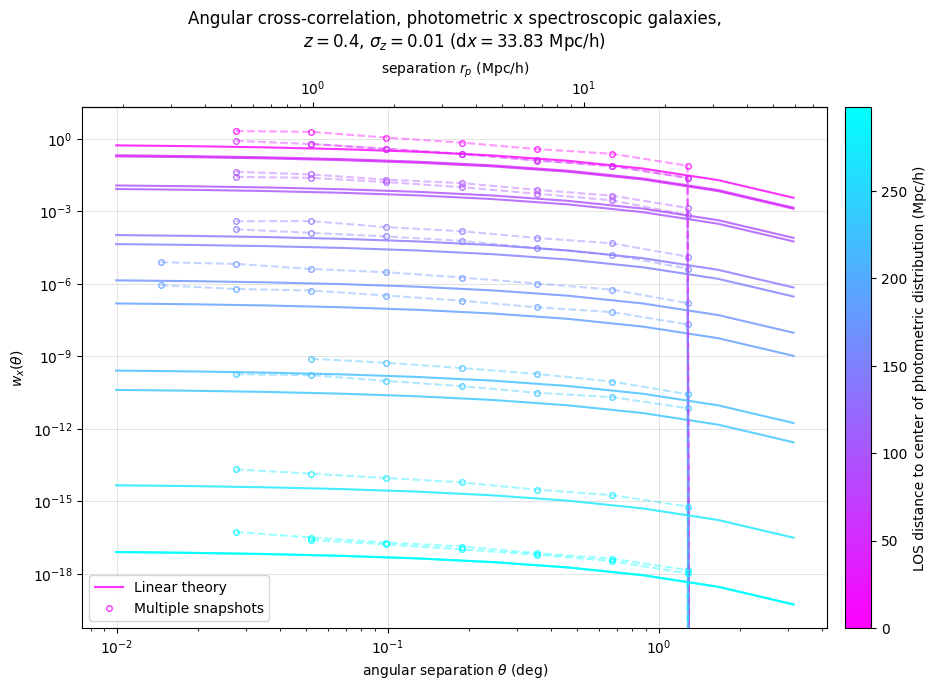

In [121]:
# now overplot the three results together
norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(chis.value-np.nanmean(chis_fine))))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig, ax = plt.subplots(figsize=(10,7), tight_layout=True)

for i, w in enumerate(wthetax):
    c = smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine)))
    
    label = 'Linear theory' if i==(len(wthetax)//2)-1 else ''
    ax.plot(thetaavg, wlin_pred[i], ls='-', c=c, alpha=0.8, label=label)
    
    label = 'Multiple snapshots' if i==(len(wthetax)//2)-1 else ''
    ax.plot(r_comov_to_theta_(rp_avg), w, ls='--', c=c, alpha=0.4)
    ax.plot(r_comov_to_theta_(rp_avg), w, ls='None', marker='o', ms=4, mec=c, mfc='None', alpha=0.8, label=label)
    
secax = ax.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.loglog()
# ax.set_ylim(1e-6,1e1)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.set_ylabel(r'$w_x(\theta)$')
fig.colorbar(smap, ax=ax, label='LOS distance to center of photometric distribution (Mpc/h)', pad=.02)
ax.set_title(f"Angular cross-correlation, photometric x spectroscopic galaxies,\n"r"$z=$"f"{sim.redshift}, "
             r"$\sigma_z=$"f"{sigma_z} ("r"d$x=$"f"{dx.value:.2f} Mpc/h)", y=1.1)
ax.legend()